In [ ]:
!pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

from pandas_profiling import ProfileReport
from sklearn.preprocessing import StandardScaler
from category_encoders.target_encoder import TargetEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, roc_curve, make_scorer

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv('customer_booking.csv', encoding='ISO-8859-1')
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

In [ ]:
df['flight_day'].unique()

array(['Sat', 'Wed', 'Thu', 'Mon', 'Sun', 'Tue', 'Fri'], dtype=object)

In [ ]:
# Converting the days of the week to a numeric type

mapping = {
    "Mon": 1,
    "Tue": 2,
    "Wed": 3,
    "Thu": 4,
    "Fri": 5,
    "Sat": 6,
    "Sun": 7,
}

df["flight_day"] = df["flight_day"].map(mapping)

In [ ]:

df["flight_day"].unique()

array([6, 3, 4, 1, 7, 2, 5])

In [ ]:
# Removing duplicates

df = df.drop_duplicates()

In [ ]:

for column in df.columns:
    print(f'Number of unique values in {column} - {df[column].nunique()}\nUnique values:\n{df[column].value_counts()}')

Number of unique values in num_passengers - 9
Unique values:
1    30879
2    12669
3     2882
4     1767
5      544
6      281
7      107
8       88
9       64
Name: num_passengers, dtype: int64
Number of unique values in sales_channel - 2
Unique values:
Internet    43917
Mobile       5364
Name: sales_channel, dtype: int64
Number of unique values in trip_type - 3
Unique values:
RoundTrip     48779
OneWay          386
CircleTrip      116
Name: trip_type, dtype: int64
Number of unique values in purchase_lead - 470
Unique values:
1      681
2      666
6      649
7      636
5      611
      ... 
463      1
460      1
453      1
584      1
867      1
Name: purchase_lead, Length: 470, dtype: int64
Number of unique values in length_of_stay - 335
Unique values:
6      7611
5      7151
4      5568
3      2798
17     1823
       ... 
242       1
392       1
431       1
513       1
329       1
Name: length_of_stay, Length: 335, dtype: int64
Number of unique values in flight_hour - 24
Unique value

In [ ]:
# Creation of functions for plotting the distribution of features

def distribution_graph(data, feat, n_bins):
    fig, ax = plt.subplots(figsize=(10, 3))

    ax.hist(data.values, bins=n_bins, color='tomato')
    ax.set_xlabel(feat + 'values')
    ax.set_ylabel('frequency')
    ax.set_title(feat+'feature distribution');

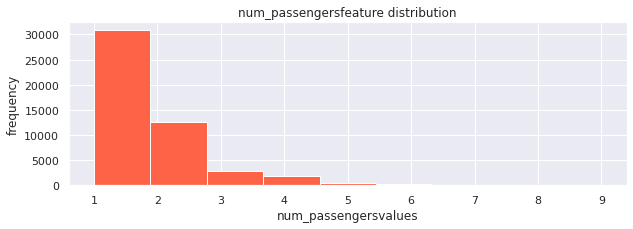

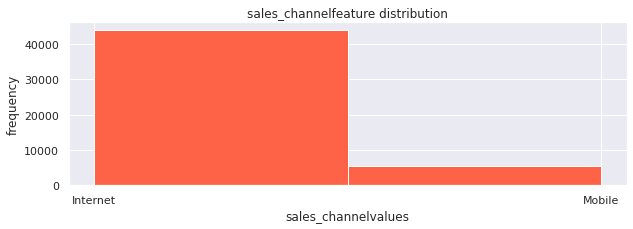

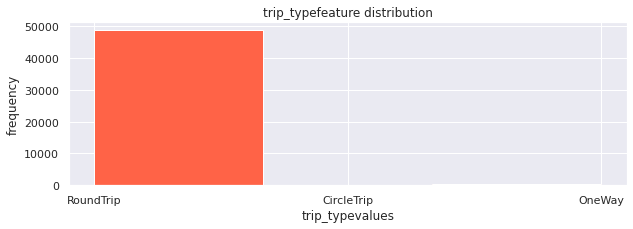

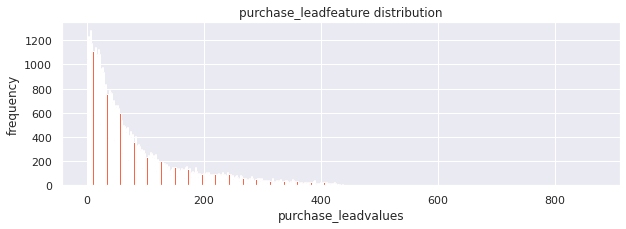

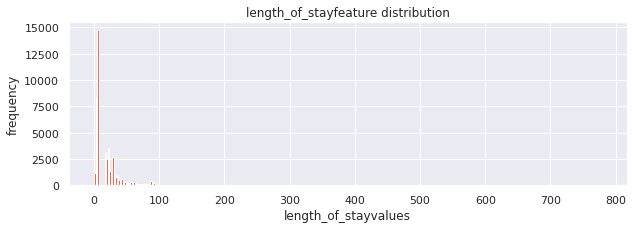

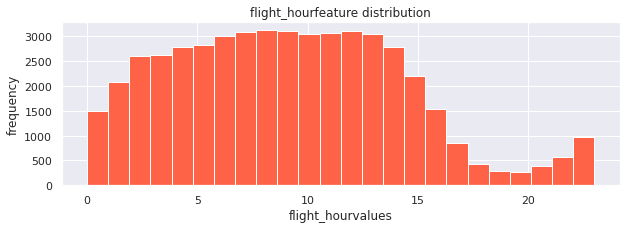

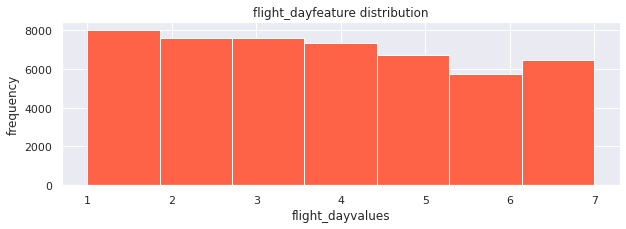

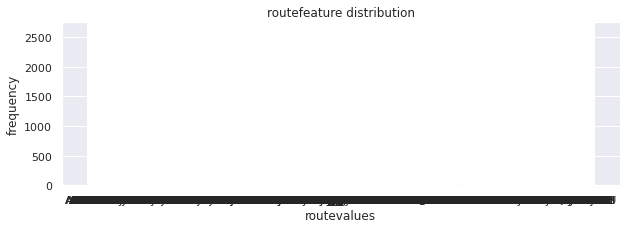

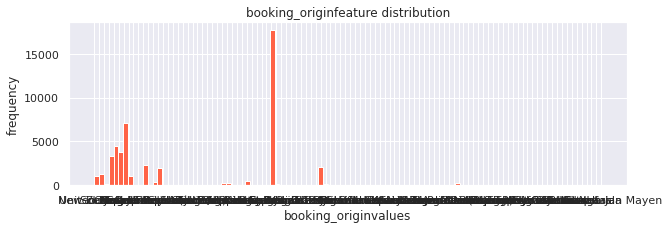

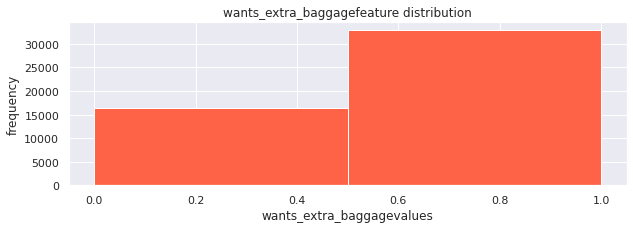

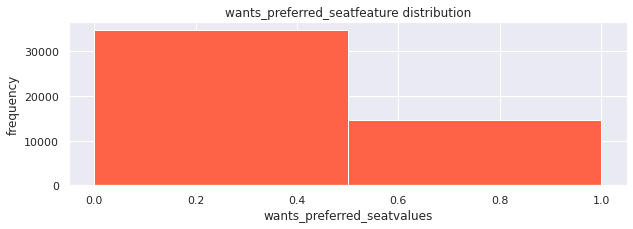

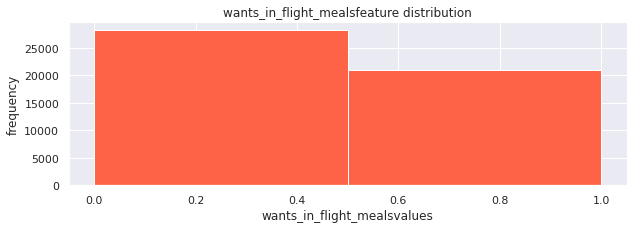

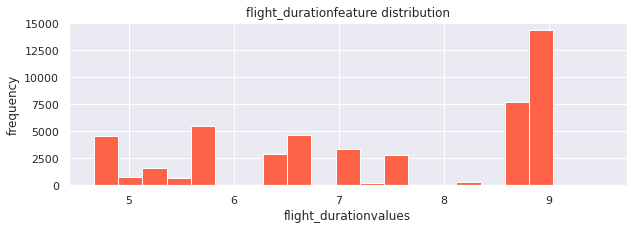

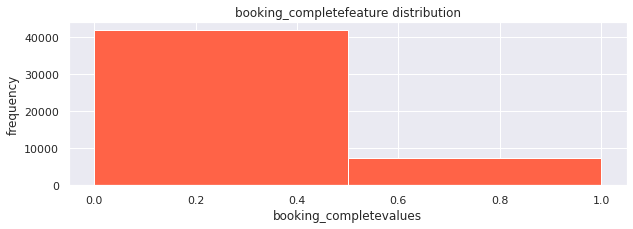

In [ ]:
# Conclusion of graphs of the distribution of feature values

for feat in df.columns:
    distribution_graph(df[feat], feat, df[feat].nunique())

In [ ]:
# Create a function to calculate the interquartile range

def calculate_outliers(data):
    q25 = data.quantile(0.25)
    q75 = data.quantile(0.75)
    iqr = q75 - q25
    boundaries = (q25 - 1.5 * iqr, q75 + 1.5 * iqr)
    return boundaries

Feature num_passengers
Lower border -  -0.5 
Upper border -  3.5 
Number of anomalies -  2851


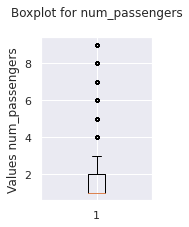

----------------------------------------
Feature sales_channel
Categorical feature
----------------------------------------
Feature trip_type
Categorical feature
----------------------------------------
Feature purchase_lead
Lower border -  -120.0 
Upper border -  256.0 
Number of anomalies -  3391


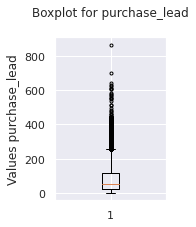

----------------------------------------
Feature length_of_stay
Lower border -  -29.5 
Upper border -  62.5 
Number of anomalies -  3748


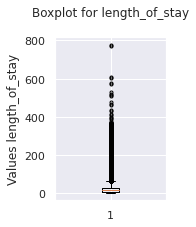

----------------------------------------
Feature flight_hour
Lower border -  -7.0 
Upper border -  25.0 
Number of anomalies -  0


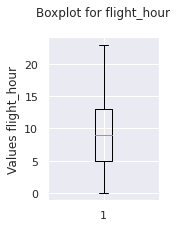

----------------------------------------
Feature flight_day
Lower border -  -2.5 
Upper border -  9.5 
Number of anomalies -  0


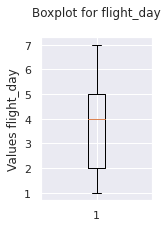

----------------------------------------
Feature route
Categorical feature
----------------------------------------
Feature booking_origin
Categorical feature
----------------------------------------
Feature wants_extra_baggage
Lower border -  -1.5 
Upper border -  2.5 
Number of anomalies -  0


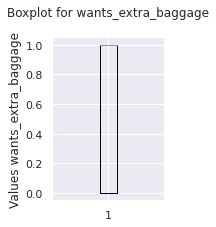

----------------------------------------
Feature wants_preferred_seat
Lower border -  -1.5 
Upper border -  2.5 
Number of anomalies -  0


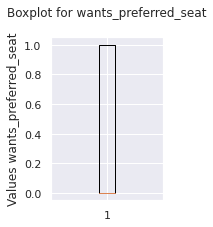

----------------------------------------
Feature wants_in_flight_meals
Lower border -  -1.5 
Upper border -  2.5 
Number of anomalies -  0


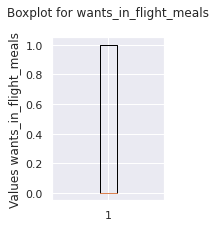

----------------------------------------
Feature flight_duration
Lower border -  0.8050000000000006 
Upper border -  13.645 
Number of anomalies -  0


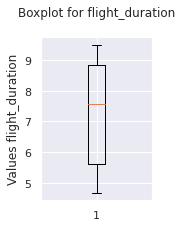

----------------------------------------
Feature booking_complete
Lower border -  0.0 
Upper border -  0.0 
Number of anomalies -  7391


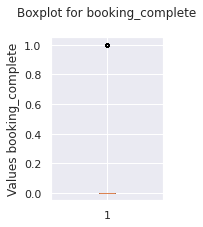

----------------------------------------


In [ ]:
# Calculation of the interquartile range, outliers and displaying a boxplot for each of the features

for feat in df.columns:
    try:
        print('Feature', feat)
        boundaries = calculate_outliers(df[feat])
        outlier = (df[feat] < boundaries[0]) | (df[feat] > boundaries[1])
        print('Lower border - ', boundaries[0], '\nUpper border - ', boundaries[1], '\nNumber of anomalies - ', outlier.sum())
    
        plt.figure(figsize=(2, 3))
        plt.boxplot(df[feat], sym='.')
        plt.ylabel('Values ' + feat) 
        plt.title('Boxplot for ' + feat + '\n')
        plt.show();
        print(f'{"-" * 40}')
    except:
        print('Categorical feature')
        print(f'{"-" * 40}')

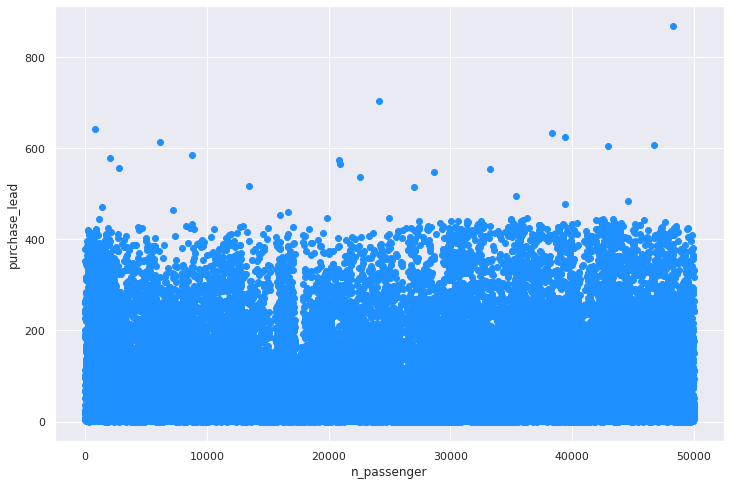

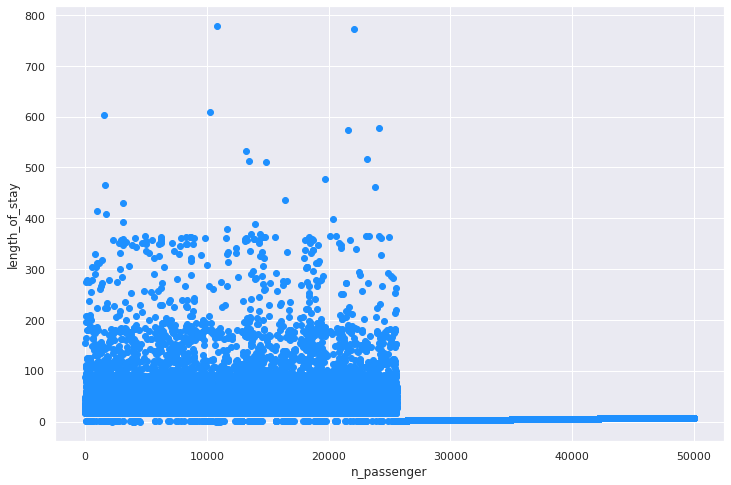

In [ ]:
columns = ['purchase_lead', 'length_of_stay']

for feat in columns:
    try:
        fig, ax = plt.subplots(figsize=(12, 8))
        ax.scatter(df.index, df[feat], c='dodgerblue')
        plt.xlabel('n_passenger')
        plt.ylabel(feat)
        plt.show();
    except:
        print('Categorical feature')

In [ ]:
# Removing anomaly(sporadic) values

df = df[df['purchase_lead'] <= 440]
df = df[df['length_of_stay'] <= 365]

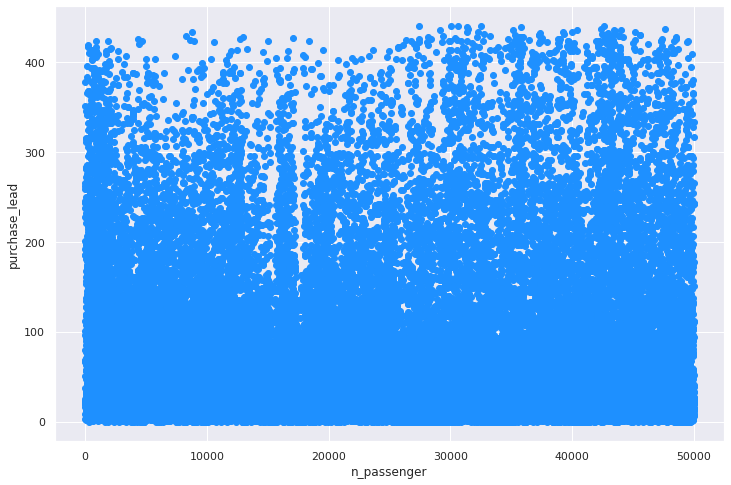

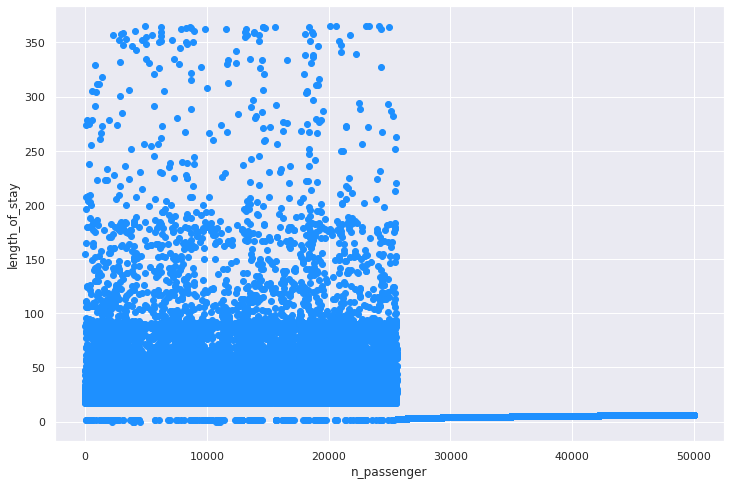

In [ ]:
columns = ['purchase_lead', 'length_of_stay']

for feat in columns:
    try:
        fig, ax = plt.subplots(figsize=(12, 8))
        ax.scatter(df.index, df[feat], c='dodgerblue')
        plt.xlabel('n_passenger')
        plt.ylabel(feat)
        plt.show();
    except:
        print('Categorical feature')

In [ ]:

# Calculation of the average value of the success of the booking from the number of days before the flight

stat = df.groupby(['purchase_lead'], as_index=False).agg({'booking_complete': 'mean'})

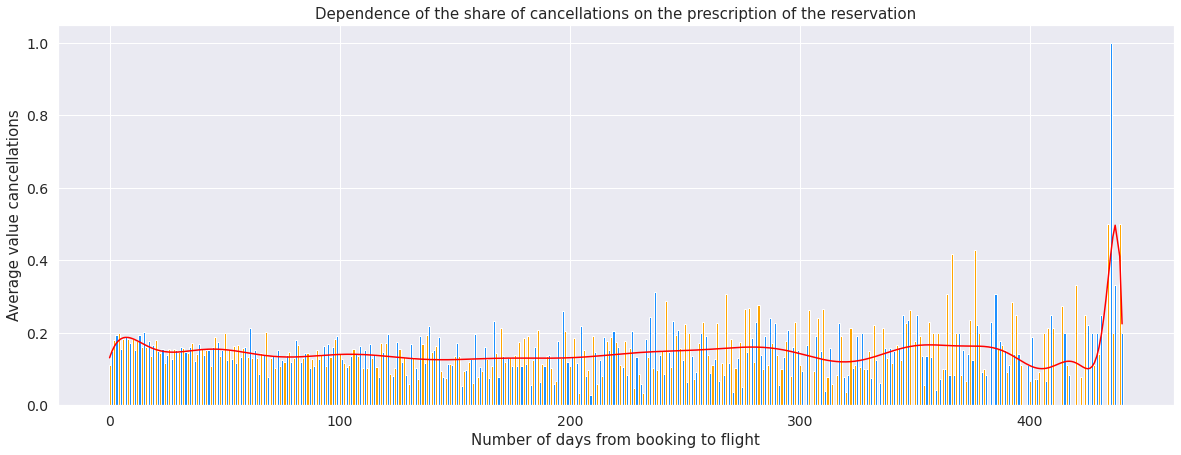

In [ ]:
fig, ax = plt.subplots(figsize=(20, 7))
ax.bar(stat['purchase_lead'], stat['booking_complete'], width=0.9, color=['orange', 'dodgerblue'])
ax.set_xlabel('Number of days from booking to flight', fontsize = 15)
ax.set_ylabel('Average value cancellations', fontsize = 15)
ax.set_title('Dependence of the share of cancellations on the prescription of the reservation', fontsize = 15)
ax.tick_params(axis='both', labelsize=14)

z = np.polyfit (stat['purchase_lead'], stat['booking_complete'], 36)
p = np.poly1d (z)
plt.plot(stat['purchase_lead'], p(stat['purchase_lead']), color='red');

In [ ]:
# Convert the number of days before the flight to months

df['purchase_lead'] = df['purchase_lead'].apply(lambda x: int(round(x / 30.5, 0)))
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,9,19,7,6,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,4,20,3,6,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,8,22,17,3,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,3,31,4,6,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,2,22,15,3,AKLDEL,India,1,0,1,5.52,0


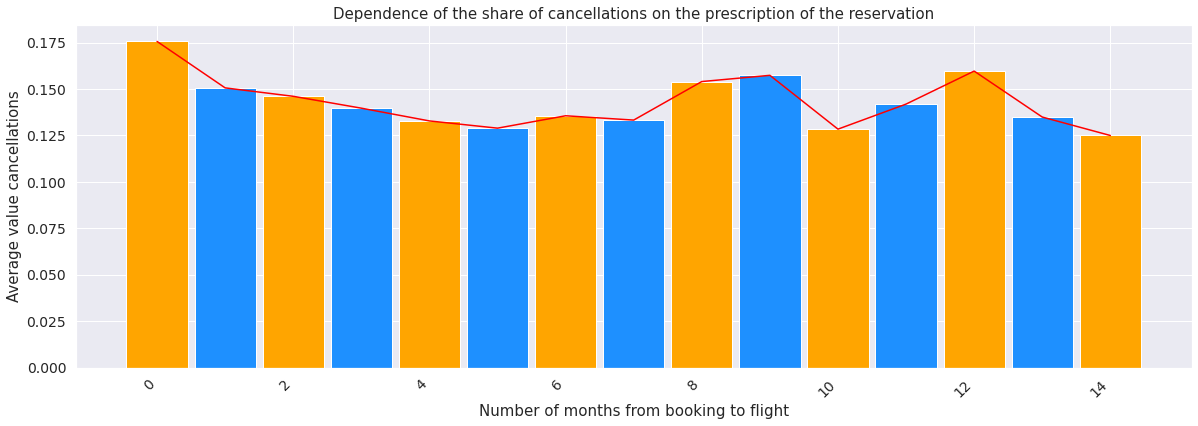

In [ ]:
stat = df.groupby(['purchase_lead'], as_index=False).agg({'booking_complete': 'mean'})

fig, ax = plt.subplots(figsize=(20, 7))
ax.bar(stat['purchase_lead'], stat['booking_complete'], width=0.9, color=['orange', 'dodgerblue'])
ax.set_xlabel('Number of months from booking to flight', fontsize = 15)
ax.set_ylabel('Average value cancellations', fontsize = 15)
ax.set_title('Dependence of the share of cancellations on the prescription of the reservation', fontsize = 15)
ax.tick_params(axis='both', labelsize=14)

z = np.polyfit (stat['purchase_lead'], stat['booking_complete'], 36)
p = np.poly1d (z)
plt.plot(stat['purchase_lead'], p(stat['purchase_lead']), color='red')

fig.autofmt_xdate(rotation=45);

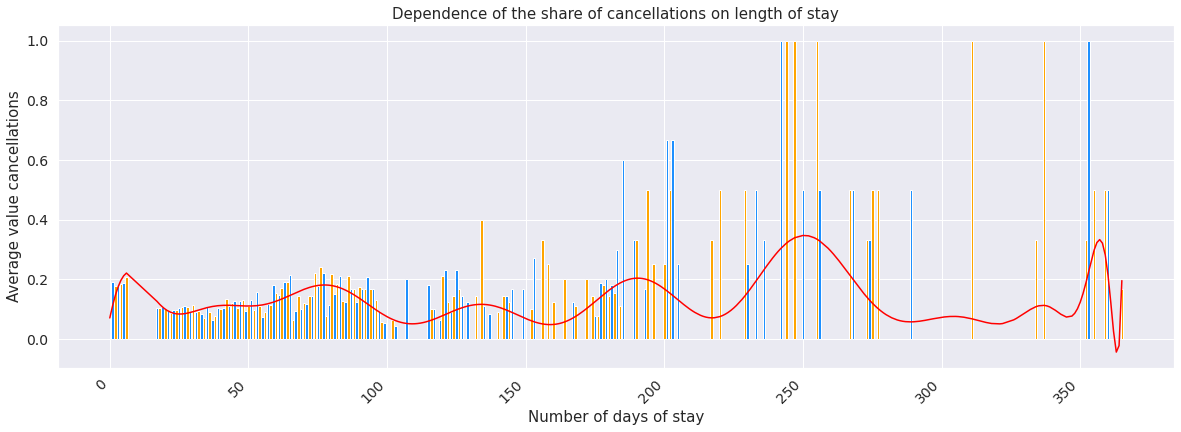

In [ ]:

# Calculation of the average value of the success of the booking from the number of days of stay

stat = df.groupby(['length_of_stay'], as_index=False).agg({'booking_complete': 'mean'})

fig, ax = plt.subplots(figsize=(20, 7))
ax.bar(stat['length_of_stay'], stat['booking_complete'], width=0.9, color=['orange', 'dodgerblue'])
ax.set_xlabel('Number of days of stay', fontsize = 15)
ax.set_ylabel('Average value cancellations', fontsize = 15)
ax.set_title('Dependence of the share of cancellations on length of stay', fontsize = 15)
ax.tick_params(axis='both', labelsize=14)

z = np.polyfit (stat['length_of_stay'], stat['booking_complete'], 36)
p = np.poly1d (z)
plt.plot(stat['length_of_stay'], p(stat['length_of_stay']), color='red')

fig.autofmt_xdate(rotation=45);

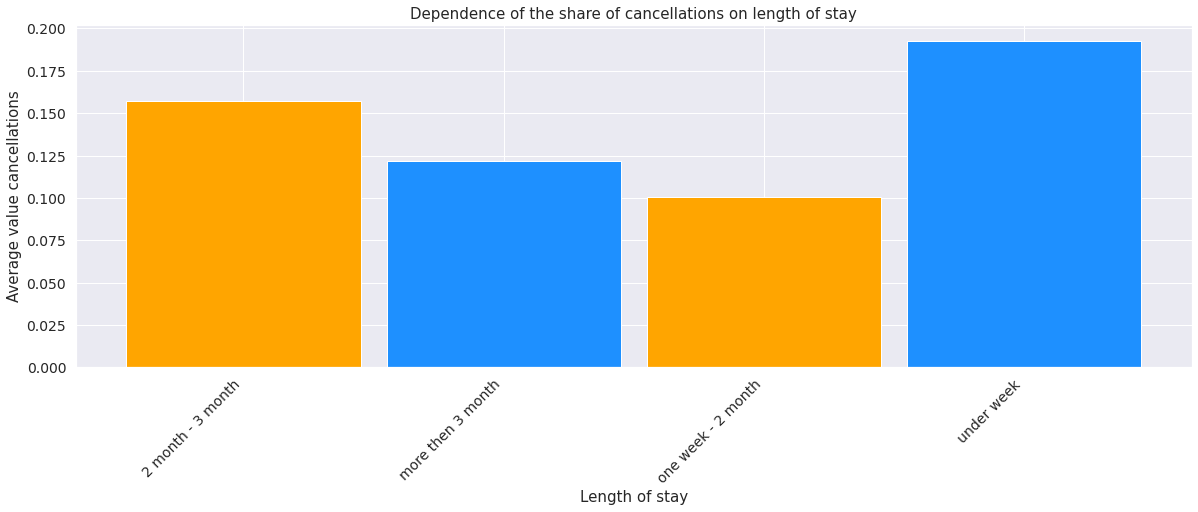

In [ ]:

# Converting the number of days of stay into intervals up to a week, from a week to 2 months, from 2 to 3 months and over 3 months

df['length_of_stay'] = df['length_of_stay'].apply(lambda x: (x <= 7 and 'under week') or 
                                                   (x > 7 and x <= 56 and 'one week - 2 month') or
                                                   (x > 56 and x <= 90 and '2 month - 3 month') or
                                                   'more then 3 month')

stat = df.groupby(['length_of_stay'], as_index=False).agg({'booking_complete': 'mean'})
fig, ax = plt.subplots(figsize=(20, 7))
ax.bar(stat['length_of_stay'], stat['booking_complete'], width=0.9, color=['orange', 'dodgerblue'])
ax.set_xlabel('Length of stay', fontsize = 15)
ax.set_ylabel('Average value cancellations', fontsize = 15)
ax.set_title('Dependence of the share of cancellations on length of stay', fontsize = 15)
ax.tick_params(axis='both', labelsize=14)
fig.autofmt_xdate(rotation=45);

In [ ]:
# Divide the route into two values - the departure and the arrival to reduce the number of unique values

df['departure'] = df.route.apply(lambda x: x[:3])
df['arrival'] = df.route.apply(lambda x: x[3:])
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete,departure,arrival
0,2,Internet,RoundTrip,9,one week - 2 month,7,6,AKLDEL,New Zealand,1,0,0,5.52,0,AKL,DEL
1,1,Internet,RoundTrip,4,one week - 2 month,3,6,AKLDEL,New Zealand,0,0,0,5.52,0,AKL,DEL
2,2,Internet,RoundTrip,8,one week - 2 month,17,3,AKLDEL,India,1,1,0,5.52,0,AKL,DEL
3,1,Internet,RoundTrip,3,one week - 2 month,4,6,AKLDEL,New Zealand,0,0,1,5.52,0,AKL,DEL
4,2,Internet,RoundTrip,2,one week - 2 month,15,3,AKLDEL,India,1,0,1,5.52,0,AKL,DEL


In [ ]:
# Transforming categorical variables with TargetEncoder

data = df[['sales_channel',  'trip_type', 'length_of_stay', 'booking_origin', 'departure', 'arrival']]

encoder = TargetEncoder(smoothing = 0.5)
for elem in data:
    df[elem+'_encoding'] = encoder.fit_transform(df[elem], df['booking_complete'])

In [ ]:
# Standardization of quantitative variables

quant_list = ['num_passengers', 'purchase_lead', 'flight_hour', 'flight_day', 'wants_extra_baggage', 'wants_preferred_seat',
              'wants_in_flight_meals', 'flight_duration']
data_quant = df[quant_list]
std_scaler = StandardScaler()
std_scaler.fit(data_quant)
std_scaled = std_scaler.transform(data_quant)
std_quant_list = ['std_scaled_' + elem for elem in quant_list]
df[std_quant_list] = std_scaled
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,...,departure_encoding,arrival_encoding,std_scaled_num_passengers,std_scaled_purchase_lead,std_scaled_flight_hour,std_scaled_flight_day,std_scaled_wants_extra_baggage,std_scaled_wants_preferred_seat,std_scaled_wants_in_flight_meals,std_scaled_flight_duration
0,2,Internet,RoundTrip,9,one week - 2 month,7,6,AKLDEL,New Zealand,1,...,0.201369,0.098361,0.403126,2.101563,-0.382296,1.097751,0.704426,-0.648032,-0.862664,-1.175719
1,1,Internet,RoundTrip,4,one week - 2 month,3,6,AKLDEL,New Zealand,0,...,0.201369,0.098361,-0.580382,0.418730,-1.121305,1.097751,-1.419596,-0.648032,-0.862664,-1.175719
2,2,Internet,RoundTrip,8,one week - 2 month,17,3,AKLDEL,India,1,...,0.201369,0.098361,0.403126,1.764997,1.465225,-0.408561,0.704426,1.543133,-0.862664,-1.175719
3,1,Internet,RoundTrip,3,one week - 2 month,4,6,AKLDEL,New Zealand,0,...,0.201369,0.098361,-0.580382,0.082164,-0.936553,1.097751,-1.419596,-0.648032,1.159200,-1.175719
4,2,Internet,RoundTrip,2,one week - 2 month,15,3,AKLDEL,India,1,...,0.201369,0.098361,0.403126,-0.254403,1.095721,-0.408561,0.704426,-0.648032,1.159200,-1.175719


In [ ]:
# Removing non-informative columns and initial features before transformations

columns_for_drop = ['sales_channel',  'trip_type', 'length_of_stay', 'booking_origin', 'departure', 'arrival', 
                   'num_passengers', 'purchase_lead', 'flight_hour', 'flight_day', 'wants_extra_baggage', 
                    'wants_preferred_seat', 'wants_in_flight_meals', 'flight_duration', 'route']
df_prepared = df.drop(columns=columns_for_drop)

In [ ]:

# Split into training and test sets

x = df.drop(['booking_complete'], axis=1)
y = df['booking_complete']

train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.3, random_state=42)

In [ ]:

# Fitting the optimal hyperparameters for LogisticRegression, RandomForestClassifier and XGBClassifier using GridSearchCV

logreg = LogisticRegression()
parametrs = { 'penalty':['l2', 'l1'],
              'C': [1E-3, 1E-2, 0.1, 1, 10, 1E2, 1E3],
              'max_iter': [100, 250, 500],
              'solver': ['newton-cg', 'lbfgs', 'saga', 'sag'],
              'class_weight': ['balanced', None, {0: 0.5, 1: 2.8}]
            }
grid = GridSearchCV(logreg, parametrs, n_jobs=-1, scoring='roc_auc', verbose=2)
grid.fit(train_x, train_y)

print(grid.best_params_)
print(grid.best_score_)

In [ ]:

rf_clf = RandomForestClassifier()
parametrs = { "n_estimators" : [100, 250, 500], 
              "max_features" : ['sqrt', 'log2', None], 
              "max_depth" : [68, 10, 12], 
              "min_samples_split" : [2, 4, 6, 8],
              "class_weight" : ['balanced_subsample', 'balanced', None, {0: 0.5, 1: 2.8}],
              "criterion": ['gini', 'entropy', 'log_loss']
            }
grid = GridSearchCV(rf_clf, parametrs, n_jobs=-1, scoring='roc_auc', verbose=1)
grid.fit(train_x, train_y)

print(grid.best_params_)
print(grid.best_score_)

In [ ]:
XGB = XGBClassifier()
parametrs = {
            'min_child_weight': [1, 5, 10],
            'gamma': [1, 2, 5],
            'subsample': [0.6, 0.8, 1.0],
            'colsample_bytree': [0.6, 0.8, 1.0],
            'max_depth': range (2, 10, 1),
            'n_estimators': range(60, 220, 40),
            'learning_rate': [0.1, 0.01, 0.05],
            'tree_method': ['gpu_hist'], 
            'gpu_id': [0]
            }


grid = GridSearchCV(XGB, parametrs, n_jobs=-1, scoring='roc_auc', verbose=1)
grid.fit(train_x, train_y)

print(grid.best_params_)
print(grid.best_score_)

In [ ]:

# Training models with optimal parameters

logreg = LogisticRegression(C=1.7, class_weight='balanced', penalty='l1', solver='saga', max_iter=500)
rf_clf = RandomForestClassifier(criterion='entropy', max_depth=12, max_features='sqrt', min_samples_split=6, n_estimators=500)
XGB = XGBClassifier(colsample_bytree=1.0, gamma=5, gpu_id=0, learning_rate=0.05, max_depth=8, 
                    min_child_weight=5, n_estimators=200, subsample=1.0, tree_method='gpu_hist')

In [ ]:
# Evaluation of each of the models using cross-validation

scoring = {'ROC_AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score)}

for model in [logreg, rf_clf, XGB]:
    cv_score = pd.DataFrame(cross_validate(model, x, y, cv=5, n_jobs=-1, scoring=scoring))
    print('Mean metrics values on cross validate:')
    print(f'Model {(str(model).split("(")[0])}:\nROC_AUC - {round(cv_score.test_ROC_AUC.mean(), 2)}\
          \nAccuracy - {round(cv_score.test_Accuracy.mean(), 2)}\n{"-" * 40}')  


In [ ]:
# Plotting ROC_AUC for models on test set

result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])

# Train the models and record the results
for model in [logreg, rf_clf, XGB]:
    train_model = model.fit(train_x, train_y)
    y_proba = train_model.predict_proba(test_x)[:,1]
    
    fpr, tpr, _ = roc_curve(test_y,  y_proba)
    auc = roc_auc_score(test_y, y_proba)
    
    result_table = result_table.append({'classifiers':model.__class__.__name__,
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc}, ignore_index=True)

# Set name of the classifiers as index labels
result_table.set_index('classifiers', inplace=True)

fig = plt.figure(figsize=(10,8))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve for test data', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show();

In [ ]:

# feature_importances for a LogisticRegression model
features = x.columns

importances = abs(logreg.coef_)[0]
indices = np.argsort(importances)

plt.title('feature Importances for a LogisticRegression model')
plt.barh(range(len(indices)), importances[indices], color='lightskyblue', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show();

In [ ]:
# feature_importances for a RandomForestClassifier model

feat_dict = dict(zip(rf_clf.feature_names_in_, rf_clf.feature_importances_))
sorted_feat_dict = {}
sorted_keys = sorted(feat_dict, key=feat_dict.get)  # [1, 3, 2]

for w in sorted_keys:
    sorted_feat_dict[w] = feat_dict[w]

plt.title('feature Importances for a RandomForestClassifier model')
plt.barh(list(sorted_feat_dict.keys()), list(sorted_feat_dict.values()), color='lightskyblue', align='center')
plt.yticks(list(sorted_feat_dict.keys()))
plt.xlabel('Relative Importance')
plt.show();

In [ ]:

# feature_importances for a XGBoost model

feature_names = XGB.get_booster().feature_names

feat_dict = dict(zip(feature_names, XGB.feature_importances_))
sorted_feat_dict = {}
sorted_keys = sorted(feat_dict, key=feat_dict.get)  # [1, 3, 2]

for w in sorted_keys:
    sorted_feat_dict[w] = feat_dict[w]

plt.title('feature Importances for a XGBoost model')
plt.barh(list(sorted_feat_dict.keys()), list(sorted_feat_dict.values()), color='lightskyblue', align='center')
plt.yticks(list(sorted_feat_dict.keys()))
plt.xlabel('Relative Importance')
plt.show();